# Sobre este notebook

Este notebook contém experiências feitas com base no livro *Data Science for Supply Chain Forecasting* do Nicolas Vandeput. Basicamente, estas experiências se resumem aos exemplos encontrados no livro.

In [1]:
#  bibliotecas

import numpy as np
import pandas as pd
from scipy.stats import norm

# 1) Moving average

In [2]:
def moving_average(d, extra_periods=1, n=3):
    # Quantidade de observações passadas
    cols=len(d)

    # Coloque valores "NA" (com np.nan) no final do vetor, para cobrir os períodos futuros
    d=np.append(d,[np.nan]*extra_periods)

    # Definindo o array/vetor de forecast
    f=np.full(cols+extra_periods,np.nan)

    # Criar todas as t+1 forecast até o fim do período histórico
    for t in range(n,cols):
        f[t]=np.mean(d[t-n:t])
    
    # Forecast para todos os períodos extras
    f[t+1:]=np.mean(d[t-n+1:t+1])

    # Retorne um data frame com a demanda, o forecast e o erro
    df=pd.DataFrame.from_dict({'Demanda':d,"Forecast":f,"Erro":d-f})

    return df

In [3]:
d=[28,19,18,13,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12,23,12,34,52,32,12,11,19,2,31,12,14,15,16,14,13,16,1,1,2,1,2,3,2,1,2,3,2,1,2,1,3,3,1,10,2,3,4,2]
df=moving_average(d,extra_periods=6,n=5);df.index.name='Período'

<AxesSubplot:title={'center':'Médias Móveis'}, xlabel='Período'>

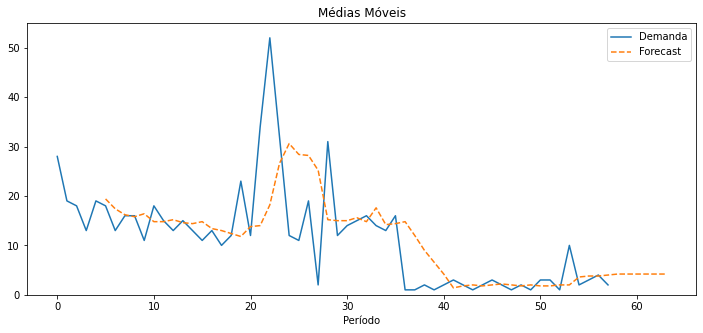

In [4]:
df[['Demanda','Forecast']].plot(figsize=(12,5),title='Médias Móveis',ylim=(0,55),style=['-','--'])


# 2) Forecast KPI

In [5]:
# Erro

df['Erro'].mean()

-0.8226415094339624

In [6]:
# Viés (bias)

def kpi(df):
    dem_ave=df.loc[df['Erro'].notnull(),'Demanda'].mean() #df.loc[linhas, colunas]
    bias_abs=df['Erro'].mean() # média dos erros, esse é o viés (bias)
    bias_rel =bias_abs/dem_ave
    print('Bias: {:.2f}, {:.2%}'.format(bias_abs,bias_rel))
    MAPE=(df['Erro'].abs()/df['Demanda']).mean() # Evite o MAPE porque erros grandes em períodos de baixa demanda vão impactar de forma significativa o MAPE
    print('MAPE: {:.2%}'.format(MAPE))
    MAE_abs=df['Erro'].abs().mean()
    MAE_rel=MAE_abs/dem_ave
    print('MAE: {:.2f}, {:.2%}'.format(MAE_abs,MAE_rel))
    RMSE_abs=np.sqrt((df['Erro']**2).mean())
    RMSE_rel=RMSE_abs/dem_ave
    print('RMSE: {:.2f}, {:.2%}'.format(RMSE_abs,RMSE_rel))
kpi(df)


Bias: -0.82, -7.60%
MAPE: 122.22%
MAE: 4.85, 44.81%
RMSE: 8.49, 78.39%


Insights:
- MAE: a gente otimiza com a mediana coincidente entre forecast e demanda (i.e: a mediana do conjunto de dados vai gerar o menor MAE possível)
- RMSE: a gente otimiza com a média coincidente entre forecast e demanda (i.e: a média do conjunto de dados vai gerar o menor RMSE possível)

Logo, é interessante verificar o MAE entre produtos no mesmo período e RMSE para cada produto ao longo dos períodos.

"MAE is aiming at demand median, and RMSE is aiming at demand average".

Tome nota: a mediana é menos sensível a valores discrepantes.

Mediana não é um bom forecast para demanda intermitente (pense num pedido de 100 a cada 3 meses. Média de 33, e mediana de 0).

"As a supply chain data scientist, you should experiment: if using MAE as a KPI results in a high bias, you might want to use RMSE. If the dataset contains many outliers, resulting in a skewed forecast, you might want to use MAE."

"Note as well that you can choose to report forecast accuracy to management using one or more KPIs (typically MAE and bias), but use another one (RMSE?) to optimize your models. We will further discuss how to manage the forecasting process in Part III."

Wisdom:  forecast of the median will get a good MAE while a forecast of the mean will get a good RMSE.


# 3) Exponential smoothing

Pro-tip: escolha alfa entre 0.05 e 0.5.

Usually, a reasonable range for α is between 0.05 and 0.5. If α is higher than 0.5, it means that the model is allocating nearly no importance to demand history. The forecast will almost solely be based on the latest observations. That would be a hint that something is wrong with the model.

$$f_{t}=\alpha d_{t-1}+(1-\alpha)f_{t-1}$$

In [7]:
def simple_exp_smooth(d, extra_periods=1, alpha=0.4): # f_{t}=a*d_{t-1}+(1-a)*f_{t-1}
    # Quantidade de observações passadas
    cols=len(d)

    # Coloque valores "NA" (com np.nan) no final do vetor, para cobrir os períodos futuros
    d=np.append(d,[np.nan]*extra_periods)

    # Definindo o array/vetor de forecast
    f=np.full(cols+extra_periods,np.nan)
    # Inicialização do primeiro forecast
    f[1]=d[0]

    # Criar todas as t+1 forecast até o fim do período histórico
    for t in range(2,cols+1):
        f[t]=alpha*d[t-1]+(1-alpha)*f[t-1]
    
    # Forecast para todos os períodos extras
    for t in range(cols+1,cols+extra_periods):
        # Atualizar o forecast como o forecast anterior
        f[t]=f[t-1]



    # Retorne um data frame com a demanda, o forecast e o erro
    df=pd.DataFrame.from_dict({'Demanda':d,"Forecast":f,"Erro":d-f})

    return df

In [8]:
df = simple_exp_smooth(d, extra_periods=4)
kpi(df)

Bias: -1.10, -9.71%
MAPE: 101.95%
MAE: 4.60, 40.79%
RMSE: 7.78, 68.99%


<AxesSubplot:title={'center':'Suavização Exponencial Simples'}>

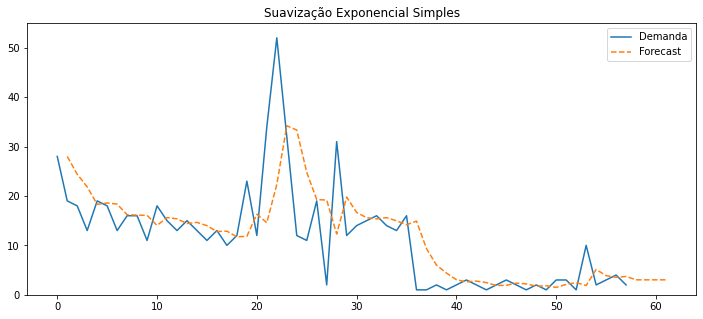

In [9]:
df[['Demanda','Forecast']].plot(figsize=(12,5),title='Suavização Exponencial Simples',ylim=(0,55),style=['-','--'])

## 4) Underfitting Model

**Underfitted model**: modelo não explica tão bem assim a realidade.

**Causas do underfitting:**
- *Model Complexity:* falta de complexidade no modelo pode fazer com que ele seja simples demais.
- *Lack of Explanatory Variables:* falta de variáveis explanatórias também complica.

# 5) Double Exponential Smoothing

Leva em consideração.

Trend: we define the trend as the **average variation of the time series level** between two consecutive periods. Remember that the level is the average value around
which the demand varies over time.

demand level: $a_{t}$
trend: $b_{t}$
demanda no periodo t: $d_{t}$
parametro da "taxa de aprendizagem entre 0 e 1": alfa

- Estimando o nível $a_{t}$:

$$a_{t}=\alpha d_{t}+(1-\alpha)(a_{t-1}+b_{t-1})$$

- Estimando a tendência $b_{t}$:

$$b_{t}=\beta(a_t-a{t-1})+(1-\beta)b_{t-1}$$

- O forecast propramente dito (forecast=Level+Trend):

$$f_{t+1}=a_{t}+b_{t}$$

- ...e para um período $t+\lambda$ qualquer:

$$f_{t+\lambda}=a_t+\lambda b_t$$


Para prever para depois do período histórico, considere a tendência constante, e que o nível e o forecast são equivalentes: ambos computados como o nível do periodo anterior mais a tendência.

$$a_t=a_{t-1}+b_{t^{*}}$$
$$b_t=b_{t^*}$$
$$f_{t+1}=a_{t}+b_{t}$$

....lembrando que $t^*$ é o último período observado.


- Modelo multiplicativo (para modelar mudancas intensas de tendência):
$$a_{t}=\alpha d_{t}+(1-\alpha)(a_{t-1}+b_{t-1})$$
$$b_{t}=\beta(\frac{a_t}{a_{t-1}})+(1-\beta)b_{t-1}$$
$$f_{t+\lambda}=a_{t}b_{t}^{\lambda}$$

- Sugestão de inicialização:
  - $a_0=d_0, \qquad{} b_0=d_1-d_0, \qquad{} f_1=a_0+b_0=d_0+(d_1-d_0)=d_1.$
  - outra forma seria fazer uma regressão linear com as $n$ primeiras observações, respeitandod aluma proporção $\frac{1}{\alpha}$ ou $\frac{1}{\beta}$.





In [10]:
def double_exp_smooth(d, extra_periods=1, alpha=0.4, beta=0.4):
    # Historical period length
    cols = len(d)
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods)
    # Creation of the level, trend and forecast arrays
    f,a,b = np.full((3,cols+extra_periods),np.nan) # aqui criamos 3 arrays vazios para f,a e b. 
    # Level & Trend initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]
    # Create all the t+1 forecast
    for t in range(1,cols):
        f[t] = a[t-1] + b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1]+b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*b[t-1]
    # Forecast for all extra periods
    for t in range(cols,cols+extra_periods):
        f[t] = a[t-1] + b[t-1]
        a[t] = f[t]
        b[t] = b[t-1]
    
    df = pd.DataFrame.from_dict({'Demanda':d,'Forecast':f,'Level':a,'Trend':b, 'Erro':d-f})

    return df

def double_exp_smooth_mult(d, extra_periods=1, alpha=0.4, beta=0.4):
    # Historical period length
    cols = len(d)
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods)
    # Creation of the level, trend and forecast arrays
    f,a,b = np.full((3,cols+extra_periods),np.nan) # aqui criamos 3 arrays vazios para f,a e b. 
    # Level & Trend initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]
    # Create all the t+1 forecast
    for t in range(1,cols):
        if t==1:
            f[t]=d[1]
        else:
            f[t] = a[t-1]*b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1]+b[t-1])
        b[t] = beta*(a[t]/a[t-1]) + (1-beta)*b[t-1]
    # Forecast for all extra periods
    for t in range(cols,cols+extra_periods):
        f[t] = a[t-1]*b[t-1]
        a[t] = f[t]
        b[t] = b[t-1]
    
    df = pd.DataFrame.from_dict({'Demanda':d,'Forecast':f,'Level':a,'Trend':b, 'Erro':d-f})

    return df


In [11]:
df = double_exp_smooth(d, extra_periods=4)
kpi(df)

Bias: 0.95, 8.46%
MAPE: 111.34%
MAE: 5.90, 52.32%
RMSE: 9.32, 82.65%


<AxesSubplot:title={'center':'Double Smoothing'}, xlabel='Period'>

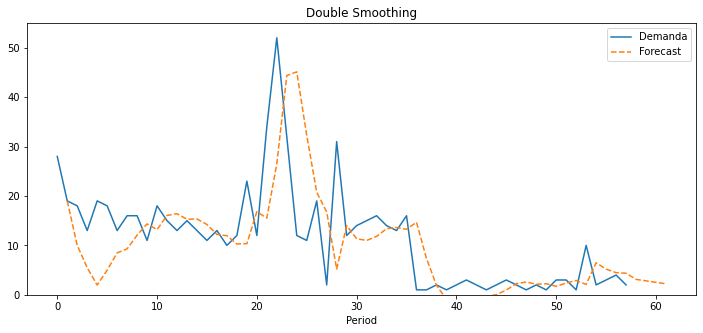

In [12]:
df.index.name = 'Period'
df[['Demanda','Forecast']].plot(figsize=(12,5), title='Double Smoothing', ylim=(0,55), style=['-','--'])


## 6) Model optimization

Aqui, vamos falar sobre hiperparametrização.

No excel, ele utiliza o solve (o que eu acho muito legal! Isso é... se tem alguma coisa de ciência de dados por de trás). 

In [13]:
def exp_smooth_opt(d, extra_periods=6,kpi="MAE"):
    params=[] # Aqui entra todas as combinações de parâmetros
    KPIs=[] # Aqui entra os resultados de cada modelo
    dfs=[] # Aqui entra todos os dataframes retornados pelos modelos ajustados

    for alfa in np.arange(0.05,0.61,0.01):
        df=simple_exp_smooth(d,extra_periods=extra_periods,alpha=alfa)
        params.append(f'Suavização exponencial simples, alfa: {alfa}')
        dfs.append(df)
        if kpi=="MAE":    
            MAE = df['Erro'].abs().mean()
            KPIs.append(MAE)
        else:
            RMSE = np.sqrt((df['Erro']**2).mean())
            KPIs.append(RMSE)
        
        for beta in np.arange(0.05,0.41,0.01):
            df=double_exp_smooth(d,extra_periods=extra_periods,alpha=alfa,beta=beta)
            params.append(f'Double Smoothing, alfa: {alfa} e beta: {beta}')
            dfs.append(df)
            if kpi=="MAE":    
                MAE = df['Erro'].abs().mean()
                KPIs.append(MAE)
            else:
                RMSE = np.sqrt((df['Erro']**2).mean())
                KPIs.append(RMSE)
            

    mini=np.argmin(KPIs)
    if kpi=="MAE":    
        print(f'E a melhor solução foi um modelo {params[mini]} com o MAE de',round(KPIs[mini],2))
    else:
        print(f'E a melhor solução foi um modelo {params[mini]} com o RMSE de',round(KPIs[mini],2))

    return dfs[mini]

exp_smooth_opt(d,kpi="RMSE")


E a melhor solução foi um modelo Suavização exponencial simples, alfa: 0.4700000000000001 com o RMSE de 7.76


,Demanda,Forecast,Erro
0,28.0,NaN,NaN
1,19.0,28.000000,-9.000000
2,18.0,23.770000,-5.770000
3,13.0,21.058100,-8.058100
4,19.0,17.270793,1.729207
...,...,...,...
59,NaN,2.919628,NaN
60,NaN,2.919628,NaN
61,NaN,2.919628,NaN
62,NaN,2.919628,NaN


E a melhor solução foi um modelo Double Smoothing, alfa: 0.28 e beta: 0.060000000000000005 com o RMSE de 58.51


<AxesSubplot:title={'center':'Suavização exponencial otimizada'}, xlabel='Period'>

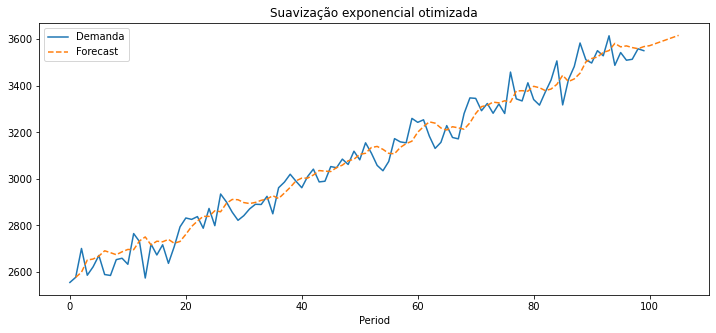

In [14]:
d=np.random.poisson(lam=2500.5,size=100)+np.tile([100,90,80,70,60,60,70,80,90,100],(1,10))[0]+np.arange(0,1000,10)
df=exp_smooth_opt(d,kpi="RMSE")
df.index.name = 'Period'
df[['Demanda','Forecast']].plot(figsize=(12,5), title='Suavização exponencial otimizada',  style=['-','--'])


# 7) Double smooth with damped trend

Artigo do Gardner e Mackenzie (1985) "Forecasting Trend in Time Series".

A ideia é que modelos com suavização exponencial mais tendência, têm o problema do forecast indo pro infinito. Aí com esse damped trend (coef $\phi$), ele meio que vai dando uma amortecida no forecast.

- Quando o $\phi=0$: suavização exponencial simples.
- Quando o $\phi=1$: double exponetial smoothing.

O modelo é igual ao double exponential smoothing, só que com o $\phi$ multiplicando todos os $b_{t-1}$.

- Estimando o nível $a_{t}$:

$$a_{t}=\alpha d_{t}+(1-\alpha)(a_{t-1}+\phi b_{t-1})$$

- Estimando a tendência $b_{t}$:

$$b_{t}=\beta(a_t-a{t-1})+(1-\beta)\phi b_{t-1}$$

- O forecast propramente dito (forecast=Level+Trend):

$$f_{t+1}=a_{t}+b_{t}\phi$$

- ...e para um período $t+\lambda$ qualquer:

$$f_{t+\lambda}=a_t+ b_t\sum_{i=1}^{\lambda}\phi^{i}$$

O ponto fraco: ainda não estamos levando em consideração a sazonalidade.

In [15]:
def double_exp_smooth_damped(d, extra_periods=1,alpha=0.4,beta=0.4,phi=0.9):
    cols=len(d) # quantidade de observações
    d=np.append(d,[np.nan]*extra_periods) # junta 'np.nan' com as observações para cobrir os períodos futuros. Meio que já deixa o espaço deles reservado rsrsrsrs

    # Criando os arrays vazios para: nível (a), tendência (b) e o forecast (f)
    f,a,b=np.full((3,cols+extra_periods),np.nan)

    # Fazendo a inicialização do a e b:
    a[0]=d[0] # No 'a' vai a primeira observação mesmo,
    b[0]=d[1]-d[0] # E aqui no 'b' vai a primeira diferença das observações

    for t in range(1,cols): # aqui, vai até o período t+1
        f[t]=a[t-1]+phi*b[t-1]
        a[t]=alpha*d[t]+(1-alpha)*(a[t-1]+phi*b[t-1])
        b[t]=beta*(a[t]-a[t-1])+(1-beta)*phi*b[t-1]

    # E aqui, fazemos o forecast para os períodos extras.
    for t in range(cols, cols+extra_periods):
        f[t]=a[t-1]+phi*b[t-1]
        a[t]=f[t]
        b[t]=phi*b[t-1]
    
    df=pd.DataFrame.from_dict({'Demanda':d,'Forecast':f,'Nível':a,'Tendência':b,'Erro':d-f})

    return df
    

In [16]:
df=double_exp_smooth_damped(d,extra_periods=5,alpha=0.28,beta=0.05,phi=0.989) # vamos usar o resultado da otimização (alfa: 0.28 e beta: 0.05)
kpi(df)

Bias: -2.06, -0.07%
MAPE: 1.52%
MAE: 46.19, 1.50%
RMSE: 57.92, 1.88%


<AxesSubplot:title={'center':'Double exponential smooth with damped trend'}, xlabel='Period'>

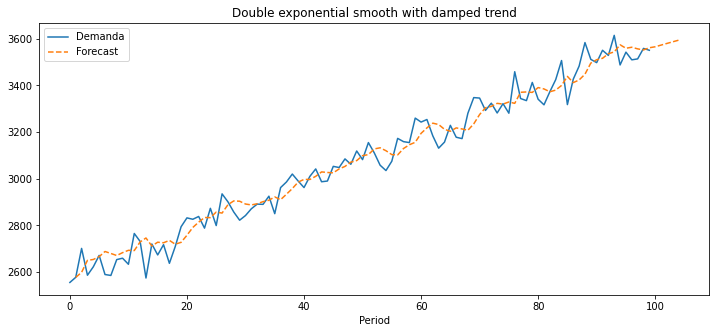

In [17]:
df.index.name = 'Period'
df[['Demanda','Forecast']].plot(figsize=(12,5), title='Double exponential smooth with damped trend',  style=['-','--'])

## 8) Overfitting

Nada de demais, ele tira o capítulo para falar sobre overfitting.

# 9) Triple exponential smoothing

Agora, entra aqui o parametro $\gamma$ da sazonalidade. O componente da sazonalidade entra multiplicando, o modelo double smooth with damped trend.

Geralmente, o componente de sazonalidade é um percentual. Exemplo: se em jan vendemos sempre 20% a mais, então o $s$ em janeiro entra como 120%.

Olha só como que fica completo o modelo agora:
$$forecast=(Level+Trend)Season$$
$$f_{t-1} = (a_t+\phi b_t)s_{t+1-p}$$


- Estimando o nível $a_{t}$:

$$a_{t}=\alpha \frac{d_{t}}{s_{t-p}}+(1-\alpha)(a_{t-1}+\phi b_{t-1})$$

- Estimando a tendência $b_{t}$:

$$b_{t}=\beta(a_t-a{t-1})+(1-\beta)\phi b_{t-1}$$

- Estimando o componente sazonal $s_{t}$:

$$s_{t}=\gamma \frac{d_t}{a_t} + (1-\gamma)s_{t-p}$$

Pro-tip: $\gamma$ tem que ir no máximo até 0.3 pra evitar overfitting.

- Future forecast:

$$f_{t+\lambda}=(a_t+\sum_{i=1}^{\lambda}\phi^{i}b_t)s_{t+\lambda-p} \text{, isso se usarmos o damping factor. Se nao, usa a expressão de baixo:}$$
$$f_{t+\lambda}=(a_t+\lambda b_t)s_{t+\lambda-p}.$$

- Componentes de inicialização

$$a_0=\frac{d_0}{s_0}$$
$$b_0=\frac{d_1}{s_1}-\frac{d_0}{s_0}$$

...agora, os componentes sazonais, é um pouco mais livre o negocio... ele dá a seguinte opção: faz uma tabela, por exemplo, as colunas são os anos e as linhas são os trimestres. Aí, você tira a média dos trimestres, padroniza/normaliza essa média dos trimestres e xablau.

Talvez dê pra tentar alguma coisa, utilizando o acf e pacf... mas fico na dúvida de como poderia encaixar.



In [18]:
def seasonal_factors_mul(s,d,slen,cols):
    for i in range(slen):
        s[i]=np.mean(d[i:cols:slen]) # Pegando a média da temporada. Esse esquema do array é assim: array[começo:fim:tamanho do passo (se de 2 em 2, 3 em 3... e etc)]
    s/=np.mean(s[:slen]) # o sinal '/=' faz o mesmo que '+=' só que divide daí.

    return s

In [19]:
#seasonal_factors_mul(s=np.full((1,len(d)+10),np.nan)[0],d=d,slen=10,cols=len(d))
#np.full((1,len(d)+12),np.nan) #np.full((quantos vetores, tamanho de cada vetor),o que colocar em cada vetor)

In [20]:
def triple_exp_smooth_mul(d, slen=12, extra_periods=1, alpha=0.4,beta=0.4, phi=0.9, gamma=0.3):
    cols = len(d) # número de observações
    d=np.append(d,[np.nan]*extra_periods) # Coloca os espaços para os períodos futuro

    # componentes de inicialização e inicialização da sazonalidade
    f,a,b,s=np.full((4,cols+extra_periods),np.nan)
    s=seasonal_factors_mul(s,d,slen,cols)

    # Inicialização do nível e tendência
    a[0]=d[0]/s[0]
    b[0]=d[1]/s[1]-d[0]/s[0]

    # Criando os forecasts para a primeira temporada (first season)
    for t in range(1,slen):
        f[t]=(a[t-1]+phi*b[t-1])*s[t]
        a[t]=alpha*d[t]/s[t]+(1-alpha)*(a[t-1]+phi*b[t-1])
        b[t]=beta*(a[t]-a[t-1])+(1-beta)*phi*b[t-1]

    # Forecast para todos os períodos, antes de chegar nos períodos extras
    for t in range(slen,cols):
        f[t]=(a[t-1]+phi*b[t-1])*s[t-slen]
        a[t]=alpha*d[t]/s[t-slen]+(1-alpha)*(a[t-1]+phi*b[t-1])
        b[t]=beta*(a[t]-a[t-1])+(1-beta)*phi*b[t-1]
        s[t]=gamma*d[t]/a[t]+(1-gamma)*s[t-slen]        

    # Forecast para todos os períodos extras
    for t in range(cols,cols+extra_periods):
        f[t]=(a[t-1]+phi*b[t-1])*s[t-slen]
        a[t]=f[t]/s[t-slen]
        b[t]=phi*b[t-1]
        s[t]=s[t-slen]

    df=pd.DataFrame.from_dict({'Demanda':d,'Forecast':f,'Nível':a,'Tendência':b,'Temporadas (seasons)':s,'Erro':d-f})

    return df


In [21]:
df=triple_exp_smooth_mul(d,slen=12,extra_periods=4,alpha=0.3,beta=0.2,phi=0.9,gamma=0.2)
kpi(df)

Bias: 5.72, 0.19%
MAPE: 1.61%
MAE: 49.37, 1.60%
RMSE: 62.05, 2.01%


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

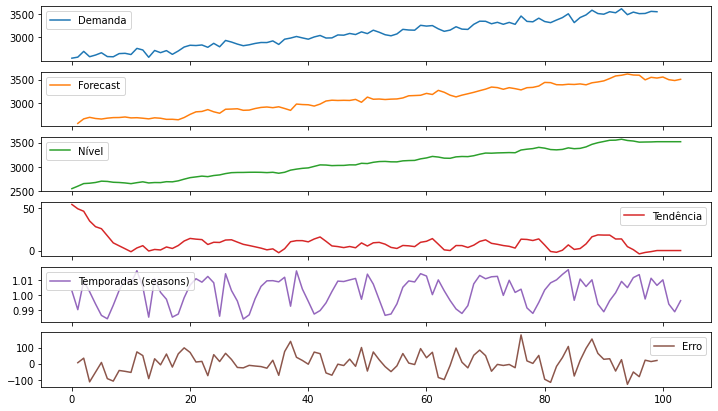

In [22]:
df.plot(subplots=True,figsize=(12,7))

## 10) Outliers

Detecção de outliers é mega necessária.

Outliers podem ser causados por erros e falhas, e demandas exepcionais.

Outlier é um valor discrepante, tanto pra cima quanto pra baixo.

### Três estratégias para lidar com outliers:

#### 1) Winsorization (winsorização... em homenagem a Charles Winsor)

- Esse 'windosrization' consiste em ficar com os dados que estão entre um quantil e outro. Geralmente, fica só com os dados que estão entre o primeiro e o último percentil

#### 2) Standard Deviation (desvio padrão)

- Assume que seu histórico de demanda segue a distribuição normal, ai você estima a distribuição e tira o percentil da distribuição propriamente dita. 

#### 3) Error standard deviation (desvio padrão do erro)

- Aqui, cobre as desvantagens em caso de sazonalidade e tendencia. Porque aí estamos olhando o desvio padrão do erro.

E é isso... todos os três métodos, visam substituir os outliers pelos valores estipulados ai dos limites.


In [23]:
def winsorization(df,higher_percentile=99,lower_percentile=1):
    d=df.dropna(subset=["Demanda"])['Demanda']
    array=np.clip(d,a_min=np.percentile(d,lower_percentile),a_max=np.percentile(d,higher_percentile)) # tome nota: a função 'clip' já substitui o outlier pelo valor limite.
    return array

#winsorization(df)

def sd_outlier_method(df,higher_percentile=.99,lower_percentile=.01):
    d=df.dropna(subset=["Demanda"])['Demanda']
    mean=np.mean(d)
    sd=np.std(d)
    limit_high=norm.ppf(higher_percentile,mean,sd) #ppf: percent point function... dá o percentil da distribuição dada.
    limit_low=norm.ppf(lower_percentile,mean,sd)
    array=np.clip(d,a_min=limit_low,a_max=limit_high)
    return array

sd_outlier_method(df)

def error_sd_outlier_method(df,higher_percentile=.8,lower_percentile=.01):
    d=df.dropna(subset=["Erro"])['Erro']
    mean=np.mean(d)
    sd=np.std(d)
    limit_high=norm.ppf(higher_percentile,mean,sd)+df['Forecast'] #ppf: percent point function... dá o percentil da distribuição dada.
    limit_low=norm.ppf(lower_percentile,mean,sd)+df['Forecast']
    array=df['Demanda'].clip(lower=limit_low,upper=limit_high)
    return array

#error_sd_outlier_method(df)

# 11) Triple Additive Exponential Smoothing

Em comparação com o último modelo, que acrescentava o componente sazonal de forma multiplicativa, este acrescenta o componente sazoznal de forma aditiva.

E ele é importante, porque não reage de forma exacerbada em situações de mudanças drásticas de demanda. Ele é mais indicado para demandas intermitentes, porém ESTÁVEIS e baixas.
Outra diferença é que o componente aditivo da sazonalidade, não vai ser uma porcentagem mas sim uma quantidade/número absoluto.

$$forecast=level+trend+seasonal \therefore f_{t+1}=a_t+\phi b_t+s_{t+1-p}$$

$$a_t=\alpha (d_t-s_{t-p})+(1-\alpha)(a_{t-1}+\phi b_{t-1})$$

$$b_t=\beta(a_t-a_{t-1})+(1-\beta)\phi b_{t-1}$$

$$s_t=\gamma(d_t-a_t)+(1-\gamma)s_{t-p}$$

Aqui neste contexto, o gamma pode ser maior que o do modelo multliplicativo (recomendação).

- Forecast futuro:

$$f_{t+\lambda}=a_t+\sum_{i=1}^{\lambda}\phi^{i} b_{t} + s_{t+\lambda-p}$$

... e se você não utilizar o damping:

$$f_{t+\lambda}=a_t + \lambda b_t + s_{t+\lambda-p}$$

Inicialização do modelo (nível e tendência):

$$a_0 = d_0 - s_0$$
$$b_0 = (d_1 - s_1) - (d_0 - s_0)$$

Como criar os componentes sazonais: faz os componentes do mesmo jeito, mas aí faz com que a soma dê zero e não um (ou seja, subtrai pela média).



In [24]:
def seasonal_factors_add(s,d,slen,cols):
    for i in range(slen):
        s[i]=np.mean(d[i:cols:slen]) # Pegando a média da temporada. Esse esquema do array é assim: array[começo:fim:tamanho do passo (se de 2 em 2, 3 em 3... e etc)]
    s-=np.mean(s[:slen]) # o sinal '-=' faz o mesmo que '+=' só que subtrai daí.
    return s

def triple_exp_smooth_add(d, slen=12, extra_periods=1, alpha=0.4,beta=0.4, phi=0.9, gamma=0.3):
    cols=len(d) # número de observações
    d=np.append(d,[np.nan]*extra_periods) # coloca os espaços vazios para os próximos períodos

    # componentes de inicialização
    f,a,b,s=np.full((4,cols+extra_periods),np.nan)
    s=seasonal_factors_add(s,d,slen,cols)

    # Inicialização do Nível e Tendência
    a[0]=d[0]-s[0]
    b[0]=(d[1]-s[1])-(d[0]-s[0])

    # criando o forecast para a primeira temporada (season)
    for t in range(1,slen):
        f[t]=a[t-1]+phi*b[t-1]+s[t]
        a[t]=alpha*(d[t]-s[t])+(1-alpha)*(a[t-1]+phi*b[t-1])
        b[t]=beta*(a[t]-a[t-1])+(1-beta)*phi*b[t-1]

    # criando todos os forecast antes dos extra periods
    for t in range(slen, cols):
        f[t]=a[t-1]+phi*b[t-1]+s[t-slen]
        a[t]=alpha*(d[t]-s[t-slen])+(1-alpha)*(a[t-1]+phi*b[t-1])
        b[t]=beta*(a[t]-a[t-1])+(1-beta)*phi*b[t-1]
        s[t] = gamma*(d[t]-a[t]) + (1-gamma)*s[t-slen]

    # criando os forecasts para os períodos futuros
    for t in range(cols, cols+extra_periods):
        f[t]=a[t-1]+phi*b[t-1]+s[t-slen]
        a[t]=f[t]-s[t-slen]
        b[t]=phi*b[t-1]
        s[t]=s[t-slen]

    df=pd.DataFrame.from_dict({'Demanda':d,'Forecast':f,'Nível':a,'Tendência':b,'Temporada (season)':s,'Erro':d-f})
#    return df


In [25]:
#df=triple_exp_smooth_add(d,slen=12,extra_periods=4,alpha=0.3,beta=0.2,phi=0.9,gamma=0.2)
#kpi(df)

# Experimento!

....projeto extra: que tal criar um otimizador considerando todos os triple models? Bora lá!

In [26]:
#np.append(np.arange(0.05,0.61,0.01),np.array([0,1]))

#np.arange(0,1.1,0.1)
# modelos:
# 1) Simple exponential smoothing
# 2) Double exponential smoothing
# 3) Double exponential smoothing with damped trend (tome nota, se phi é 0, é SES, e se phi é 1, então temos o double exponential smoothing)
# 4) Triple multipllicative exponential smoothing
# 5) Triple additive exponential smoothing

#def ultimate_exp_smooth_opt(d, extra_periods=6,kpi="MAE",alpha_range=np.arange(0.05,0.61,0.01),
#                                                         beta_range=np.arange(0.05,0.41,0.01),
#                                                         phi_range=np.arange(0,1.1,0.1),
#                                                         gamma_range_mult=np.arange(0.05,0.31,0.01),
#                                                         gamma_range_add=np.arange(0.05,0.31,0.01),slen=6):
#    params=[] # Aqui entra todas as combinações de parâmetros
#    KPIs=[] # Aqui entra os resultados de cada modelo
#    dfs=[] # Aqui entra todos os dataframes retornados pelos modelos ajustados#

    # então, a hierarquia dos 'fors' vai ser:
    # phi 3) [0,,1]Double exponential smoothing with damped trend
    #   beta 2) Double exponential smoothing
    #      alfa 1) Simple exponential smoothing
    #        gama 4)
    #        gama 5)
    # .... quer saber? Esquece esse esquema de economizar funcoes... vamos assim ó:
    # Alfa (simples) np.arange(0.05,0.61,0.01)
    #  Beta (duplo) np.arange(0.05,0.41,0.01)
    #  Beta (duplo multiplicativo... seria legal ein!) np.arange(0.05,0.41,0.01)
    #   Phi (duplo com damped trend) np.arange(0,1.1,0.1)
    #    Gama (triplo multiplicativo) np.arange(0.05,0.31,0.01)
    #    Gama (triplo aditivo) np.arange(0.05,0.31,0.01)

    # vamos lá... próximo passo, construír os 'fors'
    

#    for alfa in alpha_range:
#        df=simple_exp_smooth(d,extra_periods=extra_periods,alpha=alfa)
#        params.append(f'Simple Exp Smoothing, alpha: {alfa}.')
#        dfs.append(df)
#        if kpi=="MAE":    
#            MAE = df['Erro'].abs().mean()
#            KPIs.append(MAE)
#        else:
#            RMSE = np.sqrt((df['Erro']**2).mean())
#            KPIs.append(RMSE)
#        
#        for beta in beta_range:
#            df=double_exp_smooth(d,extra_periods=extra_periods,alpha=alfa,beta=beta)
#            params.append(f'Double Exp Smoothing additive, alpha: {alfa} and beta: {beta}.')
#            dfs.append(df)
#            if kpi=="MAE":    
#                MAE = df['Erro'].abs().mean()
#                KPIs.append(MAE)
#            else:
#                RMSE = np.sqrt((df['Erro']**2).mean())
#                KPIs.append(RMSE)#

##            df=double_exp_smooth_mult(d,extra_periods=extra_periods,alpha=alfa,beta=beta)
#            params.append(f'Double Exp Smoothing multiplicative, alpha: {alfa} and beta: {beta}.')
#            dfs.append(df)
#            if kpi=="MAE":    
#                MAE = df['Erro'].abs().mean()
#                KPIs.append(MAE)
#            else:
#                RMSE = np.sqrt((df['Erro']**2).mean())
#                KPIs.append(RMSE)#

#            for phi in phi_range:
#                df=double_exp_smooth_damped(d,extra_periods=extra_periods,alpha=alfa,beta=beta,phi=phi)
#                params.append(f'Double Exp Smoothing with Damped Trend, alpha: {alfa}, beta: {beta} and phi: {phi}.')
#                dfs.append(df)
#                if kpi=="MAE":    
#                    MAE = df['Erro'].abs().mean()
#                    KPIs.append(MAE)
#                else:
#                    RMSE = np.sqrt((df['Erro']**2).mean())
#                    KPIs.append(RMSE)
#                
#                for gamma in gamma_range_mult:
#                    df=triple_exp_smooth_mul(d,extra_periods=extra_periods,alpha=alfa,beta=beta,phi=phi,gamma=gamma,slen=slen)
#                    params.append(f'Triple Exp Smoothing Multiplicative, alpha: {alfa}, beta: {beta}, phi: {phi} and gamma: {gamma}.')
#                    dfs.append(df)
#                    if kpi=="MAE":    
#                        MAE = df['Erro'].abs().mean()
#                        KPIs.append(MAE)
#                    else:
#                        RMSE = np.sqrt((df['Erro']**2).mean())
#                        KPIs.append(RMSE)##

#                for gamma in gamma_range_add:
#                    df=triple_exp_smooth_add(d,extra_periods=extra_periods,alpha=alfa,beta=beta,phi=phi,gamma=gamma,slen=slen)
#                    params.append(f'Triple Exp Smoothing Additive, alpha: {alfa}, beta: {beta}, phi: {phi} and gamma: {gamma}.')
#                    dfs.append(df)
#                    if kpi=="MAE":    
#                        MAE = df['Erro'].abs().mean()
#                        KPIs.append(MAE)
#                    else:
#                        RMSE = np.sqrt((df['Erro']**2).mean())
#                        KPIs.append(RMSE)
            

#    mini=np.argmin(KPIs)
#    if kpi=="MAE":    
#        print(f'The best solution is the model: {params[mini]} w/ a MAE of ',round(KPIs[mini],2))
#    else:
#        print(f'The best solution is the model: {params[mini]} w/ a RMSE of',round(KPIs[mini],2))

#    return dfs[mini]


#ultimate_exp_smooth_opt(d) #uhuuuuul!!

In [27]:
# print do modelo campeão

#df = double_exp_smooth(d, extra_periods=4,alpha= 0.36000000000000004, beta=0.05)
#df.index.name = 'Period'
#df[['Demanda','Forecast']].plot(figsize=(12,5), title='Double exponential smooth',  style=['-','--'])

# 10) Machine Learning

É... meio genericona a explicação dele, mas tudo bem... vamo que vamo.

- Train and test set

olha. O approach dele é meio doido, nunca vi antes. Mas você faz meio que um loop com o seu códigio. Faz vários chunks com a sua tabela (ex: pega da linha 1 a 11, depois da 2 a 12, etc) e em cada um desses chunks você separa em treino e teste (ex: pega da linha 1 a 10 pra prever a 11, depois pega da 2 a 11 pra prever a 12 e assim por diante).

Nome aos bois:

- Tamanho do Train Set ($X$): $X_{len}$

- Tamanho do Test Set ($Y$): $Y_{len}$

- Número de observações: $n$

....logo, quantidade de loops/chunks é: $loop=1+n-X_{len}-Y_{len}$

.... olha que louco. Além desses micro-treinos-e-testes, tem um real-oficial pra cobrir uma temporada inteira (season) que ai o tamanho desse é dado pelo $S_{len}$:

$ train \qquad loops=1+n-X_{len}-Y_{len}-S_{len}$

$ test \qquad loops=S_{len}$

In [28]:
# importando os dados

def import_data(): #é... vai ser doido me acostumar com isso... criar função pra tudo kkkk
    data=pd.read_csv('norway_new_car_sales_by_make.csv')
    data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2) #esse zfill é perfeito! Coloca zero no que tá abaixo de 10. 
    df=pd.pivot_table(data=data,values='Quantity',index='Make',columns='Period',aggfunc='sum',fill_value=0) #OLHA QUE MAGICO TABELA PIVOT SUPER SIMPLES DE FAZER!!!

    return df

df=import_data()

df


Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,...,3,1,2,1,6,15,3,4,3,6
Aston Martin,0,0,1,0,4,3,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,...,685,540,551,687,794,688,603,645,827,565
BMW,352,335,365,360,431,477,403,348,271,562,...,1052,832,808,636,1031,1193,1096,1663,866,1540
Bentley,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Think,2,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Toyota,2884,1885,1833,1300,1866,1620,1901,1783,1303,1648,...,1432,1687,1603,1127,1824,1823,1327,1375,1238,1526
Volkswagen,2521,1517,1428,1257,1934,1531,1777,1665,1373,1941,...,3017,2222,2287,2076,2359,2084,2161,2106,2239,1688


In [29]:
def datasets(df, x_len=12, y_len=1, test_loops=12): # essa função fatia o dataset em de treino e teste
    D=df.values
    rows, periods= D.shape

    # Criação do dataset de treino
    loops=periods+1-x_len-y_len
    train=[]
    for col in range(loops):
        train.append(D[:,col:col+x_len+y_len])
    train=np.vstack(train)
    X_train,Y_train=np.split(train,[-y_len],axis=1)

    # Criação do dataset de teste
    if test_loops >0:
        X_train, X_test=np.split(X_train,[-rows*test_loops],axis=0)
        Y_train, Y_test=np.split(Y_train,[-rows*test_loops],axis=0)
    else: # Sem test set: X_test é usado para gerar o forecast futuro.
        X_test=D[:,-x_len:]
        Y_test=np.full((X_test.shape[0],y_len),np.nan) # Valor dummy

    # Formatação que o sklearn exige
    if y_len==1:
        Y_train=Y_train.ravel()
        Y_test=Y_test.ravel()

    return X_train,Y_train,X_test,Y_test

    

df=import_data() # fatiando o 'bicho
X_train,Y_train,X_test,Y_test=datasets(df,x_len=12,y_len=1,test_loops=12)

# agora, a regressão linear no python
from sklearn.linear_model import LinearRegression
reg=LinearRegression() # faz um objeto de regressão logística
reg=reg.fit(X_train,Y_train) # ajuste aos dados de treino
# Crie duas predições, uma para o treino e outra para o teste
Y_train_pred=reg.predict(X_train)
Y_test_pred=reg.predict(X_test)

# definindo a função para os KPIs dos MLs
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
    df=pd.DataFrame(columns=['MAE','RMSE','Bias'],index=['Train','Test'])
    df.index.name=name
    df.loc['Train','MAE']=100*np.mean(abs(Y_train-Y_train_pred))/np.mean(Y_train)
    df.loc['Train','RMSE']=100*np.sqrt(np.mean((Y_train-Y_train_pred)**2))/np.mean(Y_train)
    df.loc['Train','Bias']=100*np.mean((Y_train-Y_train_pred))/np.mean(Y_train)
    df.loc['Test','MAE']=100*np.mean(abs(Y_test-Y_test_pred))/np.mean(Y_test)
    df.loc['Test','RMSE']=100*np.sqrt(np.mean((Y_test-Y_test_pred)**2))/np.mean(Y_test)
    df.loc['Test','Bias']=100*np.mean((Y_test-Y_test_pred))/np.mean(Y_test)

    df = df.astype(float).round(2) #arredondando o número de casas decimais pra mostrar
    print(df) 

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Regression')


              MAE   RMSE  Bias
Regression                    
Train       17.85  43.91 -0.00
Test        17.82  43.68  1.65


## 13) Trees (árvores de decisão)

Árvores de decisão... simplesmente tal como a gente já conhece.
Arvore de regressão, arvore de classificação (se lembra da aula do César?)

Então. Vamos aos parâmetros:

`max_depth`: quantidade maxima de nós consecutivos que uma árvore pode ter. Quanto mais melhor, porém quanto mais, mais próximo do overfitting

`min_samples_split`: quantidade mínima de observações por nó para acionar um novo nó. Quanto menor melhor, porém quanto menos, mais próximo do overfitting

`min_samples_leaf`: quantidade mínima de observações por nó para se ter numa folha. Quanto menor melhor, porém quanto menos, mais próximo do overfitting

In [30]:
from sklearn.tree import DecisionTreeRegressor
# Instanciando uma árvore de decisão
tree=DecisionTreeRegressor(max_depth=5,min_samples_split=15,min_samples_leaf=5)
# TOME NOTA!! O parâmetro 'criterion' do DecisionTreeRegressor() faz com que a arvore seja otimizada! Seja via "mse" ou "mae". O "mae" demora mais.

# Ajuste a arvore ao dataset de treino
tree.fit(X_train,Y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=15)

In [31]:
Y_train_pred=tree.predict(X_train)
Y_test_pred=tree.predict(X_test)

kpi_ML(Y_train,Y_train_pred,Y_test,Y_test_pred,name="Tree") 

         MAE   RMSE  Bias
Tree                     
Train  18.07  43.40 -0.00
Test   21.08  52.62  3.21


## 14) Parameter Optimization

Aqui vai falar sobre k-fold cross validation e random search (random search não conheço).

- **Random Search**: é literalmente procurar um número limitado de vezes entre todos os parâmetros possíveis, qual que é o melhor. Por exemplo, se o seu modelo tem dois parametros, 5 possíveis valores para 1 e 6 possíveis valores para outro, você tem um total de 30 possíveis valores diferentes. E se você só pode testar 15 modelos, então você seleciona de forma aleatória 15 destes 30 possíveis modelos e escolhe o melhor... pronto, isso é o random search, que no python tem o nome de *grid search*.





In [32]:
# Vamos lá, preparando para fazer o teste com o CART lá

max_depth=list(range(5,11))+[None]
min_samples_split=range(5,20)
min_samples_leaf=range(2,20)

param_dist={'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf}


from sklearn.model_selection import RandomizedSearchCV
tree=DecisionTreeRegressor()
tree_cv=RandomizedSearchCV(tree,param_distributions=param_dist,
                           n_jobs=-1,cv=10,verbose=1,n_iter=100,scoring='neg_mean_absolute_error')

tree_cv.fit(X_train,Y_train)
print('Melhores parâmetros para o CART ajustado:',tree_cv.best_params_)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Melhores parâmetros para o CART ajustado: {'min_samples_split': 17, 'min_samples_leaf': 18, 'max_depth': 7}


In [33]:
Y_train_pred=tree_cv.predict(X_train)
Y_test_pred=tree_cv.predict(X_test)
kpi_ML(Y_train,Y_train_pred,Y_test,Y_test_pred,name='Tree')


         MAE   RMSE  Bias
Tree                     
Train  16.80  41.37  0.00
Test   18.13  45.52  3.09


## 15) Forest

Ideia de 'Wisdom of the crowd' do Francis Galton, aplicado a  algorítimos. No caso, em CARTS.

Modelo Ensemble: modelo construido de modelos

Bagging = bootstrap aggregation

Para o Random Forest funcionar precisamos criar novas arvores, diferentes sim porém não tão diferentes.
...e para isso, escolhemos vários training sets diferentes, de forma aleatória

dois princípios: reamostragem aleatória, e cada mini arvore com poucas features... pouca profundidade.





In [34]:
from sklearn.ensemble import RandomForestRegressor

forest=RandomForestRegressor(bootstrap=True,#Permite cada arvore crescer de forma diferente, bootstrap resampling
                             max_samples=0.9,#maior numero de amostras que uma folha pode ter para fazer o split,
                             max_features=11,#maior numero de caracteristicas que podem ser utilziadas para separar o nó,
                             min_samples_leaf=18,#menor numero de amostras que cada folha pode ter,
                             max_depth=7)# profundidade de cada árvore)
forest.fit(X_train,Y_train)

Y_train_pred=forest.predict(X_train)
Y_test_pred=forest.predict(X_test)
kpi_ML(Y_train,Y_train_pred,Y_test,Y_test_pred,name='Forest')

          MAE   RMSE  Bias
Forest                    
Train   15.80  40.24 -0.03
Test    18.29  47.05  3.69


In [35]:
from sklearn.model_selection import RandomizedSearchCV


max_depth = list(range(5,11)) + [None]
min_samples_split = range(5,20)
min_samples_leaf = range(2,15)
max_features = range(3,8)
bootstrap = [True] #We force bootstrap
max_samples = [.7,.8,.9,.95,1]

param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'bootstrap': bootstrap,
              'max_samples': max_samples}

forest = RandomForestRegressor(n_jobs=1, n_estimators=30)
forest_cv = RandomizedSearchCV(forest, param_dist, cv=6, n_jobs=-1, verbose=2, n_iter=400, scoring='neg_mean_absolute_error')
forest_cv.fit(X_train,Y_train)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits


RandomizedSearchCV(cv=6,
                   estimator=RandomForestRegressor(n_estimators=30, n_jobs=1),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 6, 7, 8, 9, 10, None],
                                        'max_features': range(3, 8),
                                        'max_samples': [0.7, 0.8, 0.9, 0.95, 1],
                                        'min_samples_leaf': range(2, 15),
                                        'min_samples_split': range(5, 20)},
                   scoring='neg_mean_absolute_error', verbose=2)

In [36]:
print('Tuned Forest Parameters:', forest_cv.best_params_)
print()
Y_train_pred = forest_cv.predict(X_train)
Y_test_pred = forest_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest optimized')

Tuned Forest Parameters: {'min_samples_split': 18, 'min_samples_leaf': 8, 'max_samples': 0.9, 'max_features': 5, 'max_depth': 8, 'bootstrap': True}

                    MAE   RMSE  Bias
Forest optimized                    
Train             14.73  36.86  0.05
Test              17.87  45.79  3.04


In [37]:
# bora fazer um exemplo monstro?

forest = RandomForestRegressor(n_estimators=200, n_jobs=-1, **forest_cv.best_params_) #esses dois asteriscos facilitam a vida! Sabe as listas de param no R? Então,
                                                                                      #pensa que nem toda a funcao tem esse param=list(). Então, no python
                                                                                      # vc cria o dict com os parametros que vc quer ai vc passa com '**nome_do_dict'
                                                                                      #como argumento e boa. Ele já faz um expand.grid pra vc!
forest = forest.fit(X_train, Y_train)
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forestx200')


              MAE   RMSE  Bias
Forestx200                    
Train       14.59  36.97  0.08
Test        17.80  45.90  3.12


## 16) Feature Importance

Pensa que a gente quer saber o impacto que cada 'feature' (no nosso caso... mês) tem na acuracidade de forecast
 Ai então essa importância é normalizada e posta em gráfico.

 

<AxesSubplot:>

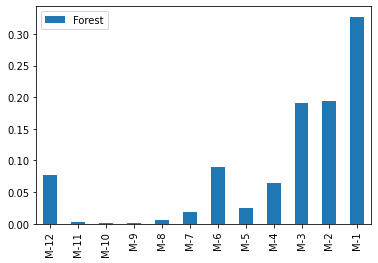

In [38]:
#bora fazer esse gráfico

cols = X_train.shape[1] # number of columns in our training sets
features = [f'M-{cols-col}' for col in range(cols)]  # output: ['M-12', 'M-11', 'M-10', 'M-9', 'M-8', 'M-7', 'M-6', 'M-5', 'M-4', 'M-3', 'M-2', 'M-1']
data = forest.feature_importances_.reshape(-1,1) #aqui ó... já existe o trem, se chama 'feature_importances_'
imp = pd.DataFrame(data=data, index=features, columns=['Forest'])
imp.plot(kind='bar')


## 17) Extremely Randomized Trees

Ele torna aleatória o surgimento de novas árvores e novos splits... coloca mais um 'tempero' de bootstrap na receita



In [39]:
from sklearn.ensemble import ExtraTreesRegressor

ETR = ExtraTreesRegressor(n_jobs=-1, n_estimators=200, min_samples_split=15, min_samples_leaf=4, max_samples=0.95, max_features=4, max_depth=8, bootstrap=True)
ETR.fit(X_train,Y_train)
Y_train_pred = ETR.predict(X_train)
Y_test_pred = ETR.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR')


         MAE   RMSE  Bias
ETR                      
Train  17.67  43.37  0.02
Test   18.69  46.54  3.04


In [40]:
#vamos otimizar esse extreme random forest:

max_depth = list(range(6,13)) + [None]
min_samples_split = range(7,16)
min_samples_leaf = range(2,13)
max_features = range(5,13)
bootstrap = [True] #We force bootstrap
max_samples = [.7,.8,.9,.95,1]
param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'bootstrap': bootstrap,
              'max_samples': max_samples}

ETR = ExtraTreesRegressor(n_jobs=1, n_estimators=30)
ETR_cv = RandomizedSearchCV(ETR, param_dist, cv=5, verbose=2, n_jobs=-1, n_iter=400, scoring='neg_mean_absolute_error')
ETR_cv.fit(X_train,Y_train)
print('Tuned Forest Parameters:', ETR_cv.best_params_)
print()
Y_train_pred = ETR_cv.predict(X_train)
Y_test_pred = ETR_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR optimized')

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Tuned Forest Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_samples': 0.8, 'max_features': 12, 'max_depth': 10, 'bootstrap': True}

                 MAE   RMSE  Bias
ETR optimized                    
Train          14.35  35.47 -0.01
Test           17.56  44.97  2.67


## 18) Feature Optimization

aqui o foco é otimizar as variáveis explicativas

Simplesmente colocar mais variáveis, vai saturar o modelo (o autor diz que é overfitting... não concordo)

Mas será que existe um 'ponto ótimo' de acrescentar variáveis? Que nem quando a gente via os testes de verossimilhanca e/ou BIC

Criação de partições, dos k-folds e etc

Holdout set: A holdout set is a subset of the training set that is kept aside during the training in order to validate a model against unseen data. The holdout set is made of the last periods of the training set in order to replicate a test set. (achei ridículo esse holdout set... desnecessário, não faz sentido. É mais uma etapa desnecessária que gera mais custo computacional).

Model
ETR Test        12
ETR Train       48
Forest Test     28
Forest Train    44
dtype: int64


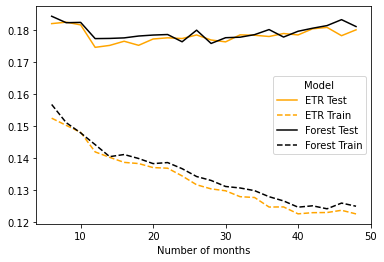

In [41]:
df = import_data()
forest_features = {'n_jobs':-1, 'n_estimators':200, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_samples': 0.95, 'max_features': 0.3, 'max_depth': 8, 'bootstrap': True}

forest = RandomForestRegressor(**forest_features)
ETR_features = {'n_jobs':-1, 'n_estimators':200, 'min_samples_split':14, 'min_samples_leaf': 2, 'max_samples': 0.9, 'max_features': 1.0,'max_depth': 12, 'bootstrap': True}

ETR = ExtraTreesRegressor(**ETR_features)
models = [('Forest',forest), ('ETR',ETR)]

def model_mae(model, X, Y):
    Y_pred = model.predict(X)
    mae = np.mean(np.abs(Y - Y_pred))/np.mean(Y)
    return mae

n_months = range(6,50,2)
results = []
for x_len in n_months: # We loop through the different x_len
    X_train, Y_train, X_test, Y_test = datasets(df, x_len=x_len)
    for name, model in models: # We loop through the models
        model.fit(X_train,Y_train)
        mae_train = model_mae(model, X_train, Y_train)
        mae_test = model_mae(model, X_test, Y_test)
        results.append([name+' Train',mae_train,x_len])
        results.append([name+' Test',mae_test,x_len])

data = pd.DataFrame(results,columns=['Model','MAE%','Number of Months'])
data = data.set_index(['Number of Months','Model']).stack().unstack('Model')
data.index = data.index.droplevel(level=1)
data.index.name = 'Number of months'
data.plot(color=['orange']*2+['black']*2,style=['-','--']*2)
print(data.idxmin())

Model
ETR Test        12
ETR Train       42
ETR Val         42
Forest Test     24
Forest Train    44
Forest Val      42
dtype: int64


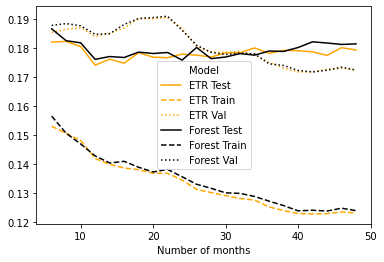

In [42]:
from sklearn.model_selection import KFold
n_months = range(6,50,2)
results = []
for x_len in n_months:
    X_train, Y_train, X_test, Y_test = datasets(df, x_len=x_len)
    for name, model in models:
        mae_kfold_train = []
        mae_kfold_val = []
        for train_index, val_index in KFold(n_splits=8).split(X_train):
            X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
            Y_train_kfold, Y_val_kfold = Y_train[train_index], Y_train[val_index]
            model.fit(X_train_kfold, Y_train_kfold)
            mae_train = model_mae(model, X_train_kfold, Y_train_kfold)
            mae_kfold_train.append(mae_train)
            mae_val = model_mae(model, X_val_kfold, Y_val_kfold)
            mae_kfold_val.append(mae_val)
        results.append([name+' Val',np.mean(mae_kfold_val),x_len])
        results.append([name+' Train',np.mean(mae_kfold_train),x_len])
        
        model.fit(X_train,Y_train)
        mae_test = model_mae(model, X_test, Y_test)
        results.append([name+' Test',mae_test,x_len])

data = pd.DataFrame(results,columns=['Model','MAE%','Number of Months'])
data = data.set_index(['Number of Months','Model']).stack().unstack('Model')
data.index = data.index.droplevel(level=1)
data.index.name = 'Number of months'
data.plot(color=['orange']*3+['black']*3,style=['-','--',':']*2)
print(data.idxmin())

## 19) Adaptative Boosting
Várias arvores fracas pra fazer uma boa previsão
é melhor ir direto para o Gradient Boosting ou XGBoosting. É tbm um método de arvore mas ao inves do bagging é utilizado o boosting.

Weak Model: um modelo que acerta um pouco mais que um chute aleatório.

Boosting: uma classe de algorítimos essemble em que modelos são adicionados sequencialmente, de modo que os ultimos modelos na sequência vão corrigir as previsões dos modelos anteriores.

Bagging versus Boosting: https://www.upgrad.com/blog/bagging-vs-boosting/#:~:text=Bagging%20is%20a%20method%20of%20merging%20the%20same,bias%2C%20and%20solves%20over-fitting%20issues%20in%20a%20model.

"Bagging is a method of merging the same type of predictions. Boosting is a method of merging different types of predictions."

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=100, learning_rate=0.25, loss='square')
ada = ada.fit(X_train,Y_train)

Y_train_pred = ada.predict(X_train)
Y_test_pred = ada.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='AdaBoost')

            MAE   RMSE  Bias
AdaBoost                    
Train      7.38  15.82 -0.29
Test      18.37  46.81  4.02


In [44]:
#n_estimators = [100]
learning_rate = [0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35]
loss = ['square','exponential','linear']
param_dist = {#'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'loss':loss}

def model_mae(model, X, Y):
    Y_pred = model.predict(X)
    mae = np.mean(np.abs(Y - Y_pred))/np.mean(Y)
    return mae


from sklearn.model_selection import RandomizedSearchCV
results = []
for max_depth in range(2,18,2):
    ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth))
    ada_cv = RandomizedSearchCV(ada, param_dist, n_jobs=-1, cv=6, n_iter=20, scoring='neg_mean_absolute_error')
    ada_cv.fit(X_train,Y_train)
    print('Tuned AdaBoost Parameters:',ada_cv.best_params_)
    print('Result:',ada_cv.best_score_)
    results.append([ada_cv.best_score_,ada_cv.best_params_, max_depth])


Tuned AdaBoost Parameters: {'loss': 'exponential', 'learning_rate': 0.01}
Result: -51.914751934552804
Tuned AdaBoost Parameters: {'loss': 'exponential', 'learning_rate': 0.05}
Result: -33.56211413676076
Tuned AdaBoost Parameters: {'loss': 'square', 'learning_rate': 0.05}
Result: -32.27041859264774
Tuned AdaBoost Parameters: {'loss': 'linear', 'learning_rate': 0.05}
Result: -31.764681070795735
Tuned AdaBoost Parameters: {'loss': 'linear', 'learning_rate': 0.3}
Result: -31.59081373769421
Tuned AdaBoost Parameters: {'loss': 'exponential', 'learning_rate': 0.15}
Result: -31.891879692413003
Tuned AdaBoost Parameters: {'loss': 'exponential', 'learning_rate': 0.01}
Result: -32.14902917558445
Tuned AdaBoost Parameters: {'loss': 'square', 'learning_rate': 0.15}
Result: -32.03384835440165


In [45]:
results = pd.DataFrame(data=results, columns=['Score','Best Params', 'Max Depth'])
optimal = results['Score'].idxmax()
print(results.iloc[optimal])

Score                                        -31.590814
Best Params    {'loss': 'linear', 'learning_rate': 0.3}
Max Depth                                            10
Name: 4, dtype: object


In [46]:
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=100,learning_rate=0.005,loss='linear')
ada = ada.fit(X_train,Y_train)
Y_train_pred = ada.predict(X_train)
Y_test_pred = ada.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='AdaBoost optimized')


                      MAE   RMSE  Bias
AdaBoost optimized                    
Train                8.00  19.01  0.24
Test                18.62  48.92  5.68


## 20) Demand Drivers and Leading Indicators

Aqui vamos abordar como incorporar outras variáveis além do histórico de demanda.

External Factors são chamados de Leading Indicators.

Fatores Endogenos: histórico de demanda

Fatores Exogenos: ou interno (Marketing Promotions Price) ou Externo (Weather GDP Oil Price)

Demand drivers and machine learning. Como inserir: no nosso caso aqui, insere como se fosse mais um produto no modelo de machine learning

In [47]:
#df = import_data()
#GDP = pd.read_excel('GDP.xlsx').set_index('Year')
#dates = pd.to_datetime(df.columns,format='%Y-%m').year
#X_GDP = [GDP.loc[date,'GDP'] for date in dates]
#yep... esse aqui nao vai da pra rodar pq nao temos os dados do GDP

def datasets_exo(df, X_exo, x_len=12, y_len=1, test_loops=12):
    D = df.values
    rows, periods = D.shape
    X_exo = np.repeat(np.reshape(X_exo,[1,-1]),rows,axis=0)
    X_months = np.repeat(np.reshape([int(col[-2:]) for col in df.columns],[1,-1]),rows,axis=0)

    # Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    for col in range(loops):
        m = X_months[:,col+x_len].reshape(-1,1) #month
        exo = X_exo[:,col:col+x_len] #exogenous data
        d = D[:,col:col+x_len+y_len]
        train.append(np.hstack([m, exo, d]))
    train = np.vstack(train)
    X_train, Y_train = np.split(train,[-y_len],axis=1)

    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train,[-rows*test_loops],axis=0)
        Y_train, Y_test = np.split(Y_train,[-rows*test_loops],axis=0)
    else: # No test set: X_test is used to generate the future forecast
        X_test = np.hstack([m[:,-1].reshape(-1,1),X_exo[:,-x_len:], D[:,-x_len:]])
        Y_test = np.full((X_test.shape[0],y_len),np.nan) #Dummy value
    # Formatting required for scikit-learn
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()

    return X_train, Y_train, X_test, Y_test

## 21) Gradient Boosting

Bom, aqui vai falar sobre o XGBoost. E como o autor mesmo descreve:

-   XGBoost is faster.
-   XGBoost is (generally) better
-   XGBoost allows for more parameters to be optimized

Early Stopping: uma forma inteligente de parar o modelo antes de testar exaustivamente todas as alternativas.

In [56]:
from xgboost.sklearn import XGBRegressor
XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=100, learning_rate=0.2)
XGB = XGB.fit(X_train, Y_train)

In [60]:
#import xgboost as xgb
#XGB.get_booster().feature_names = [f'M{x-12}' for x in range(12)]
#xgb.plot_importance(XGB, importance_type='total_gain', show_values=False) # não sei o que aconteceu aqui

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
# Training and testing
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=6, test_loops=12)
XGB = XGBRegressor(n_jobs=1, max_depth=10, n_estimators=100,learning_rate=0.2)
multi = MultiOutputRegressor(XGB, n_jobs=-1)
multi.fit(X_train,Y_train)
# Future Forecast
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=6, test_loops=0)
XGB = XGBRegressor(n_jobs=1, max_depth=10, n_estimators=100,learning_rate=0.2)
multi = MultiOutputRegressor(XGB, n_jobs=-1)
multi.fit(X_train,Y_train)
forecast = pd.DataFrame(data=multi.predict(X_test), index=df.index)

from sklearn.model_selection import train_test_split # usando Early Stopping e Evaluation Set
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.15)
XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=1000, learning_rate=0.01)
#XGB = XGB.fit(x_train, y_train, early_stopping_rounds=100, verbose=True, eval_set=[(x_eval,y_eval)], eval_metric='mae')
XGB = XGB.fit(x_train, y_train, early_stopping_rounds=100, verbose=False, 
              eval_set=[(x_train, y_train), (x_val, y_val)],eval_metric='mae',
              callbacks = [xgb.callback.print_evaluation(period=50)])
print(f'Best iteration: {XGB.get_booster().best_iteration}')
print(f'Best score: {XGB.get_booster().best_score}')

In [ ]:
# avaliando o modelo com mais do que uma métrica

XGB = XGB.fit(x_train, y_train, early_stopping_rounds=100,
              verbose=False, eval_set=[(x_train, y_train), (x_val, y_val)],
              eval_metric=['rmse','mae'], callbacks = [xgb.callback.print_evaluation(period=50)])

In [ ]:
fit_params = {'early_stopping_rounds':25,
              'eval_set':[(x_val, y_val)],
              'eval_metric':'mae',
              'verbose':False}
XGB = XGBRegressor(n_jobs=1, max_depth=10, n_estimators=100,learning_rate=0.2)
multi = MultiOutputRegressor(XGB, n_jobs=-1)
multi.fit(X_train,Y_train,**fit_params)


In [ ]:
# vamos fazer uma otimização de parâmetros!

params = {'max_depth': [5,6,7,8,10,11],
          'learning_rate': [0.005,0.01,0.025,0.05,0.1,0.15],
          'colsample_bynode': [0.5,0.6,0.7,0.8,0.9,1.0],#max_features
          'colsample_bylevel': [0.8,0.9,1.0],
          'colsample_bytree': [0.6,0.7,0.8,0.9,1.0],
          'subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7],#max_samples
          'min_child_weight': [5,10,15,20,25],#min_samples_leaf
          'reg_alpha': [1,5,10,20,50],
          'reg_lambda': [0.01,0.05,0.1,0.5,1],
          'n_estimators':[1000]}

fit_params = {'early_stopping_rounds':25,
              'eval_set':[(x_val, y_val)],
              'eval_metric':'mae',
              'verbose':False}
XGB = XGBRegressor(n_jobs=1)
XGB_cv = RandomizedSearchCV(XGB, params, cv=5, n_jobs=-1, verbose=1, n_iter=1000, scoring='neg_mean_absolute_error')
XGB_cv.fit(x_train, y_train,**fit_params)
print('Tuned XGBoost Parameters:',XGB_cv.best_params_)


# Agora, com o XGBoost otimizado, temos os seguintes resultados:

best_params = XGB_cv.best_params_
XGB = XGBRegressor(n_jobs=-1, **best_params)
XGB = XGB.fit(x_train, y_train, **fit_params)
print(f'Best iteration: {XGB.get_booster().best_iteration}')
print(f'Best score: {XGB.get_booster().best_score}')
Y_train_pred = XGB.predict(X_train)
Y_test_pred = XGB.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='XGBoost')

## 22) Categorical Features


É entrar a variável categórica como número... para o modelo levar em consideração.

Não funciona para variável categórica nominal. Para estes casos, usar one-hot encoding, ou variáveis dummy.



In [62]:
# Exemplo: categoria pra carro

luxury = ['Aston Martin','Bentley','Ferrari','Lamborghini','Lexus', 'Lotus','Maserati','McLaren','Porsche','Tesla']
premium = ['Audi','BMW','Cadillac','Infiniti','Land Rover','MINI','Mercedes-Benz','Jaguar']
low_cost = ['Dacia','Skoda']
df['Segment'] = 2 #By default all brands are normal
mask = df.index.isin(luxury) #Luxury = 4
df.loc[mask,'Segment'] = 4
mask = df.index.isin(premium) #Premium = 3
df.loc[mask,'Segment'] = 3
mask = df.index.isin(low_cost) #Low cost = 1
df.loc[mask,'Segment'] = 1

print(df)


Period        2007-01  2007-02  2007-03  2007-04  2007-05  2007-06  2007-07  \
Make                                                                          
Alfa Romeo         16        9       21       20       17       21       14   
Aston Martin        0        0        1        0        4        3        3   
Audi              599      498      682      556      630      498      562   
BMW               352      335      365      360      431      477      403   
Bentley             0        0        0        0        0        1        0   
...               ...      ...      ...      ...      ...      ...      ...   
Think               2        0        0        1        0        0        0   
Toyota           2884     1885     1833     1300     1866     1620     1901   
Volkswagen       2521     1517     1428     1257     1934     1531     1777   
Volvo             693      570      656      587      805      662     1064   
Westfield           0        0        0        0    

In [64]:
df['Brand'] = df.index
df['Brand'] = df['Brand'].astype('category').cat.codes

# outra forma:
#df['Brand'] = df.index.astype('category').codes

In [ ]:
# criando variáveis dummies

df['Brand'] = df.index
df = pd.get_dummies(df, columns=['Brand'], prefix_sep='_')

print(df)

def datasets_cat(df, x_len=12, y_len=1, test_loops=12, cat_name='_'):

    col_cat = [col for col in df.columns if cat_name in col]
    D = df.drop(columns=col_cat).values # Historical demand
    C = df[col_cat].values # Categorical info
    rows, periods = D.shape

    # Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    for col in range(loops):
        train.append(D[:,col:col+x_len+y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train,[-y_len],axis=1)
    X_train = np.hstack((np.vstack([C]*loops),X_train))

    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train,[-rows*test_loops],axis=0)
        Y_train, Y_test = np.split(Y_train,[-rows*test_loops],axis=0)
    else: # No test set: X_test is used to generate the future forecast
        X_test = np.hstack((C,D[:,-x_len:]))
        Y_test = np.full((X_test.shape[0],y_len),np.nan) #Dummy value

    # Formatting required for scikit-learn
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()

    return X_train, Y_train, X_test, Y_test

In [ ]:
df = import_data()
df['Segment'] = 2
mask = df.index.isin(luxury)
df.loc[mask,'Segment'] = 4
mask = df.index.isin(premium)
df.loc[mask,'Segment'] = 3
mask = df.index.isin(low_cost)
df.loc[mask,'Segment'] = 1
X_train, Y_train, X_test, Y_test = datasets_cat(df, x_len=12, y_len=1, test_loops=12, cat_name='Segment')
df = import_data()
df['Brand'] = df.index
df = pd.get_dummies(df, columns=['Brand'], prefix_sep='_')
X_train, Y_train, X_test, Y_test = datasets_cat(df, x_len=12, y_len=1, test_loops=12, cat_name='_')


## 23) Clustering

Aqui vai mostrar os métodos de analise de cluster... k-means e etc.

E algumas dicas legais de como clusterizar... de repente, é o que precisa pra identificar o que é demanda intermitente, lumpy, etc...

The question you should ask yourself is: what are the features I want to categorize my products on? Depending on each dataset, you might prefer different approaches. Here are some ideas:

- Volume We can obviously start categorizing products based on their sales volume. Most likely, this categorization won’t provide so much added value, as you could just do a good old Pareto Classification3 to get a similar result.

- Additive Seasonality If we cluster the products based on their additive seasonality factors (as defined in Chapter 11), we will cluster them based on their average volume and  their seasonality. You might then end up with groups containing just a few products.

- Multiplicative Seasonality If we take the multiplicative seasonal factors (as defined in Chapter 9), our products will then be categorized only based on their seasonal behavior—irrespective of their absolute size. This sounds much better.

Depois que faz o cluster, joga ele no modelo como uma variável dummy

In [69]:
# Bora testar. Vamos achar os clusters de sazonalidade:

def seasonal_factors(df,slen):
    s = pd.DataFrame(index=df.index)
    for i in range(slen):
        s[i+1] = df.iloc[:,i::slen].mean(axis=1)
        s = s.divide(s.mean(axis=1),axis=0).fillna(0)
    return s

# agora uma outra função pra padronizar as escalas

def scaler(s):
    mean = s.mean(axis=1)
    maxi = s.max(axis=1)
    mini = s.min(axis=1)
    s = s.subtract(mean,axis=0)
    s = s.divide(maxi-mini,axis=0).fillna(0)
    return s


# agora, back to the data

df = import_data()
s = seasonal_factors(df,slen=12)
s = scaler(s)
print(s.head())

                    1         2         3         4         5         6   \
Make                                                                       
Alfa Romeo   -0.154393 -0.154389 -0.154354 -0.154219 -0.153544 -0.151302   
Aston Martin  0.742022 -0.157978  0.017022  0.108688  0.133897  0.168730   
Audi         -0.084915 -0.084915 -0.084915 -0.084915 -0.084915 -0.084915   
BMW          -0.084900 -0.084900 -0.084900 -0.084900 -0.084900 -0.084900   
Bentley       0.879944  0.079944 -0.060056 -0.120056 -0.120056 -0.044456   

                    7         8         9         10        11        12  
Make                                                                      
Alfa Romeo   -0.141093 -0.107013 -0.040120  0.080438  0.284382  0.845607  
Aston Martin -0.001953 -0.217746 -0.079447 -0.257978 -0.197278 -0.257978  
Audi         -0.084915 -0.084915 -0.084910 -0.084589 -0.066267  0.915085  
BMW          -0.084900 -0.084900 -0.084897 -0.084638 -0.066365  0.915100  
Bentley      -0.0

<AxesSubplot:xlabel='Number of clusters'>

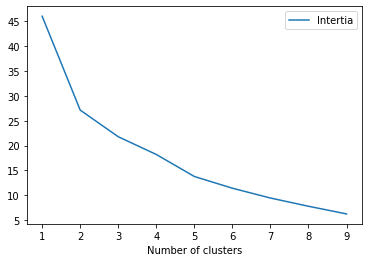

In [72]:
# agura, usar k-means

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(s)
df['Group'] = kmeans.predict(s)

# verificando a inércia (???) Inercia é o Elbow method...

results = []
for n in range(1,10):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(s)
    results.append([n, kmeans.inertia_])
results = pd.DataFrame(data=results,columns=['Number of clusters','Intertia']).set_index('Number of clusters')
results.plot()




<AxesSubplot:>

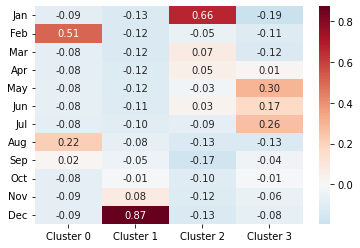

In [75]:
import calendar
kmeans = KMeans(n_clusters=4, random_state=0).fit(s)
centers = pd.DataFrame(data=kmeans.cluster_centers_).transpose()
centers.index = calendar.month_abbr[1:]
centers.columns = [f'Cluster {x}' for x in range(centers.shape[1])]

import seaborn as sns
sns.heatmap(centers, annot=True, fmt='.2f', center=0, cmap='RdBu_r')


In [77]:
# number of products per cluster:

print(df['Group'].value_counts().sort_index())


0    10
1    38
2     9
3     8
Name: Group, dtype: int64


## 24) Feature Optimization

Aqui é sobre backpropagation... enfim. Seleção de covariáveis, não faz sentido pegar não.

## 25) Neural Networks

Cara, aqui ele começa a falar da febre das redes neurais nos anos 2010. 
2012: a revolução começa no ImageNet Large Scale Vision Recognition Challenge. Onde o time do Alex Krizhevsky ficou em primeiro lugar, com um resultado melhor (metade do erro) do segundo colocado. Ele usou rede neural convolucional numa GPU.

Bem legal... ele fala bastante sobre a história das redes neurais.



In [80]:
from sklearn.neural_network import MLPRegressor
NN = MLPRegressor().fit(X_train, Y_train)

hidden_layer_sizes = [[neuron]*hidden_layer for neuron in range(10, 60,10) for hidden_layer in range(2,7)]
alpha = [5,1,0.5,0.1,0.05,0.01,0.001]
learning_rate_init = [0.05,0.01,0.005,0.001,0.0005]
beta_1 = [0.85,0.875,0.9,0.95,0.975,0.99,0.995]
beta_2 = [0.99,0.995,0.999,0.9995,0.9999]
param_dist = {'hidden_layer_sizes':hidden_layer_sizes, 'alpha':alpha,'learning_rate_init':learning_rate_init,
              'beta_1':beta_1, 'beta_2':beta_2}

activation = 'relu'
solver = 'adam'
early_stopping = True
n_iter_no_change = 50
validation_fraction = 0.1
tol = 0.0001
param_fixed = {'activation':activation, 'solver':solver, 'early_stopping':early_stopping, 
               'n_iter_no_change': n_iter_no_change, 'validation_fraction':validation_fraction,'tol':tol}

NN = MLPRegressor(hidden_layer_sizes=(20,20), **param_fixed, verbose=True).fit(X_train, Y_train)


Iteration 1, loss = 39793.58031919
Validation score: 0.857643
Iteration 2, loss = 7260.26102389
Validation score: 0.869467
Iteration 3, loss = 5940.99043213
Validation score: 0.888788
Iteration 4, loss = 5337.70820772
Validation score: 0.899311
Iteration 5, loss = 4843.36012426
Validation score: 0.904510
Iteration 6, loss = 4553.32949357
Validation score: 0.908209
Iteration 7, loss = 4132.46029749
Validation score: 0.913198
Iteration 8, loss = 4118.89848884
Validation score: 0.916528
Iteration 9, loss = 3935.34636846
Validation score: 0.918753
Iteration 10, loss = 3763.50028160
Validation score: 0.913907
Iteration 11, loss = 3579.99449183
Validation score: 0.920802
Iteration 12, loss = 3558.86935915
Validation score: 0.922319
Iteration 13, loss = 3468.17300780
Validation score: 0.923195
Iteration 14, loss = 3466.54298975
Validation score: 0.924468
Iteration 15, loss = 3432.27343177
Validation score: 0.923950
Iteration 16, loss = 3273.45983345
Validation score: 0.928036
Iteration 17, lo

In [ ]:
NN = MLPRegressor(**param_fixed)
NN_cv = RandomizedSearchCV(NN, param_dist, cv=10, verbose=2, n_jobs=-1, n_iter=200, scoring='neg_mean_absolute_error')
NN_cv.fit(X_train,Y_train)
print('Tuned NN Parameters:', NN_cv.best_params_)
print()
Y_train_pred = NN_cv.predict(X_train)
Y_test_pred = NN_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='NN optimized')

## 26) Judgmental Forecasts

nossa... aqui ele soltou algumas verdades rsrsrsrs

Em resumo: sempre vai ter alguem dando pitaco no seu forecast... e tbm, nas empresas existem conflitos de interesses.

É preciso ser humilde pra ouvir e abosrver esses pitacos. Uma sugestão, é na reunião de S&Op pedir os pitacos de todo o mundo de forma anonima, fazer tipo um "Wisdom of the Crowd" e então tomar a decisão

## 27) Forecast Value Added

Aqui é sobre como avaliar os baselines dos modelos e como progredir com os forecasts.

- Smart Weighting: é a questão de levar em consideração o preço e tamanho da peça, por exemplo. Veja abaixo o weighted forecast error:

$$e_w = w(f-d)$$

Onde $w$ é o peso, a "importancia" no caso, $f$ é o forecast e $d$ o realizado.

Forecast Value Added (FVA): crie um benchmark e conflite os resultados do modelo com esse benchmark. o FVA é o quanto que o modelo melhora o forecast em relacao ao benchmark (ex: o benchmark é replicar o ultimo valor observado e o modelo é o SES. O MAE do benchmark é 30% e o do SES é 25%, então o FVA foi de 5%).

...no caso da volvo, o benchmark é o CICS!

